<a href="https://colab.research.google.com/github/mohamedshouaib/iti/blob/main/Computer_Vision/Day01/siamesenetwork_imageverification_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mohamedshouaib/iti.git
!cd iti/Computer_Vision/Day01/Siamese

Cloning into 'iti'...
remote: Enumerating objects: 2507, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 2507 (delta 36), reused 18 (delta 18), pack-reused 2459 (from 3)
Receiving objects: 100% (2507/2507), 128.92 MiB | 14.48 MiB/s, done.
Resolving deltas: 100% (351/351), done.
Updating files: 100% (1857/1857), done.


In [2]:
import os
import cv2
import csv
import time
import random
import numpy as np
from google.colab.patches import cv2_imshow
from itertools import combinations
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def load_dataset(base_path="iti/Computer_Vision/Day01/Siamese"):
    data = {'train': {}, 'test': {}}

    for person in os.listdir(base_path):
        person_path = os.path.join(base_path, person)
        if not os.path.isdir(person_path):
            continue

        for split in ['Train', 'Test']:
            split_path = os.path.join(person_path, split)
            if not os.path.exists(split_path):
                print(f"Missing {split} folder for {person}")
                continue

            csv_files = [f for f in os.listdir(split_path) if f.endswith('.csv')]
            if not csv_files:
                print(f"No CSV found in {split_path}")
                continue

            csv_path = os.path.join(split_path, csv_files[0])

            genuine = []
            forged = []

            with open(csv_path, 'r') as f:
                try:
                    reader = csv.DictReader(f)
                    row = next(reader)

                    img_col = None
                    label_col = None

                    for col in row.keys():
                        col_lower = col.lower()
                        if 'image' in col_lower or 'name' in col_lower:
                            img_col = col
                        elif 'label' in col_lower or 'class' in col_lower:
                            label_col = col

                    if not img_col or not label_col:
                        raise ValueError("Couldn't detect required columns")

                    f.seek(0)
                    next(reader)

                    for row in reader:
                        img_name = row[img_col].strip()
                        img_path = os.path.join(split_path, img_name)

                        if not os.path.exists(img_path):
                            print(f"Missing image: {img_path}")
                            continue

                        label = row[label_col].strip().lower()
                        if label == 'real' or label == 'genuine':
                            genuine.append(img_path)
                        elif label == 'forged' or label == 'fake':
                            forged.append(img_path)

                except Exception as e:
                    print(f"Error reading {csv_path}: {str(e)}")
                    continue

            if genuine or forged:
                data[split.lower()][person] = {
                    'genuine': genuine,
                    'forged': forged
                }

    return data['train'], data['test']

print("Checking folder structure...")
base_path = "iti/Computer_Vision/Day01/Siamese"
print(f"Root contents: {os.listdir(base_path)}")
sample_person = os.listdir(base_path)[0]
print(f"Sample person contents: {os.listdir(os.path.join(base_path, sample_person))}")

train_data, test_data = load_dataset(base_path)

print("\nLoaded successfully!")
print(f"Persons in train: {list(train_data.keys())}")
print(f"Persons in test: {list(test_data.keys())}")

Checking folder structure...
Root contents: ['personD', 'personC', 'personA', 'personE', 'personB']
Sample person contents: ['Train', 'Test']

Loaded successfully!
Persons in train: ['personD', 'personC', 'personA', 'personE', 'personB']
Persons in test: ['personD', 'personC', 'personA', 'personE', 'personB']


In [4]:
def generate_triplets(data_dict, split='train'):
    triplets = []
    persons = list(data_dict[split].keys())

    for person in persons:
        genuine = data_dict[split][person]['genuine']
        forged = data_dict[split][person]['forged']

        for i in range(len(genuine)):
            for j in range(i+1, len(genuine)):
                anchor = genuine[i]
                positive = genuine[j]

                for neg in forged:
                    triplets.append((anchor, positive, neg))

    return triplets

In [5]:
train_triplets = generate_triplets({'train': train_data, 'test': test_data}, split='train')
test_triplets = generate_triplets({'train': train_data, 'test': test_data}, split='test')

In [6]:
sample_path = train_triplets[0][0]
sample_img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
true_height, true_width = sample_img.shape
print(f"Actual image dimensions: {true_height}x{true_width}")

input_shape = (true_height, true_width, 1)

Actual image dimensions: 397x612


In [7]:
def load_triplet_images(triplet, img_size=(150, 150)):
    def load_image(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Failed to load image: {path}")
        img = cv2.resize(img, img_size)
        return img.astype(np.float32) / 255.0

    anchor = load_image(triplet[0])
    positive = load_image(triplet[1])
    negative = load_image(triplet[2])

    return anchor, positive, negative

In [8]:
train_data, test_data = load_dataset("iti/Computer_Vision/Day01/Siamese")

In [9]:
def show_triplet(triplet):
    try:
        anchor, positive, negative = load_triplet_images(triplet)

        if anchor.max() <= 1.0:
            anchor = (anchor * 255).astype(np.uint8)
            positive = (positive * 255).astype(np.uint8)
            negative = (negative * 255).astype(np.uint8)

        h, w = anchor.shape
        separator = np.ones((h, 5), dtype=np.uint8) * 255
        combined = np.hstack([anchor, separator, positive, separator, negative])

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(combined, 'Anchor', (5, 20), font, 0.5, 255, 1)
        cv2.putText(combined, 'Positive', (w+10, 20), font, 0.5, 255, 1)
        cv2.putText(combined, 'Negative', (2*w+15, 20), font, 0.5, 255, 1)

        try:
            from google.colab.patches import cv2_imshow
            cv2_imshow(combined)
        except:
            cv2.imshow('Triplet', combined)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

    except Exception as e:
        print(f"Error displaying triplet: {e}")
        print(f"Triplet paths: {triplet}")

In [10]:
def show_multiple_triplets(triplets, num_to_show=10):
    print(f"Showing {min(num_to_show, len(triplets))} triplets out of {len(triplets)}\n")
    for i in range(min(num_to_show, len(triplets))):
        print(f"Triplet #{i + 1}")
        show_triplet(triplets[i])

Generated 19000 train triplets
Generated 120 test triplets
Showing 10 triplets out of 19000

Triplet #1


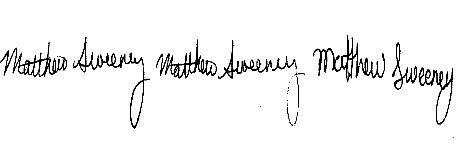

Triplet #2


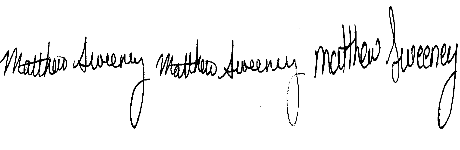

Triplet #3


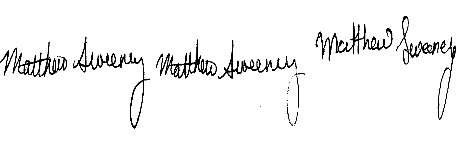

Triplet #4


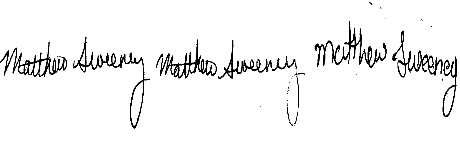

Triplet #5


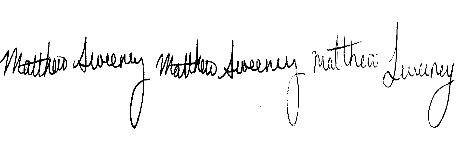

Triplet #6


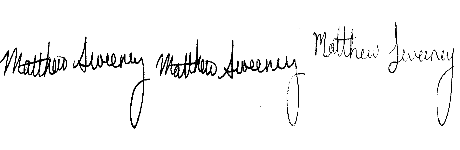

Triplet #7


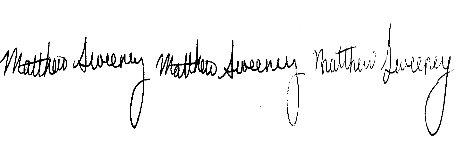

Triplet #8


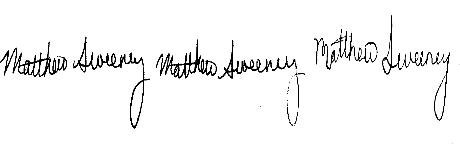

Triplet #9


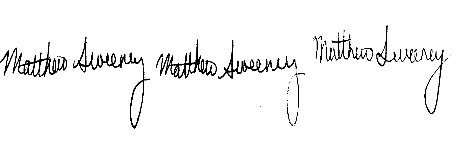

Triplet #10


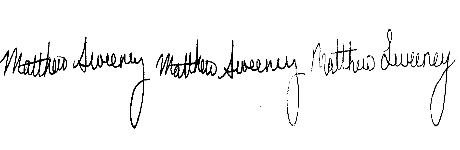

In [11]:
print(f"Generated {len(train_triplets)} train triplets")
print(f"Generated {len(test_triplets)} test triplets")
show_multiple_triplets(train_triplets, num_to_show=10)

In [12]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 150, 150)
            dummy_output = self.cnn(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).shape[1]
            print(f"[INFO] Flattened feature size: {self.flattened_size}")

        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, anchor, positive, negative):
        out_anchor = self.forward_once(anchor)
        out_positive = self.forward_once(positive)
        out_negative = self.forward_once(negative)
        return out_anchor, out_positive, out_negative


In [13]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_pos = F.pairwise_distance(anchor, positive)
        distance_neg = F.pairwise_distance(anchor, negative)
        losses = F.relu(distance_pos - distance_neg + self.margin)
        return losses.mean()


In [14]:
class TripletDataset(Dataset):
    def __init__(self, triplets, img_size=(150, 150)):
        self.triplets = triplets
        self.img_size = img_size

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        a, p, n = self.triplets[idx]
        anchor, positive, negative = load_triplet_images((a, p, n), self.img_size)

        anchor = torch.tensor(anchor).unsqueeze(0)
        positive = torch.tensor(positive).unsqueeze(0)
        negative = torch.tensor(negative).unsqueeze(0)

        return anchor, positive, negative

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
loss_fn = TripletLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0000005)

train_dataset = TripletDataset(train_triplets)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for anchor, positive, negative in loop:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        out_a, out_p, out_n = model(anchor, positive, negative)
        loss = loss_fn(out_a, out_p, out_n)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}")


[INFO] Flattened feature size: 73984


Epoch 1/10: 100%|██████████| 594/594 [03:08<00:00,  3.15it/s, loss=0.311]


Epoch 1, Loss: 0.6343333595479378


Epoch 2/10: 100%|██████████| 594/594 [03:06<00:00,  3.18it/s, loss=0.0215]


Epoch 2, Loss: 0.1674575674996683


Epoch 3/10: 100%|██████████| 594/594 [03:06<00:00,  3.19it/s, loss=0.0108]


Epoch 3, Loss: 0.0231643314379258


Epoch 4/10: 100%|██████████| 594/594 [03:06<00:00,  3.19it/s, loss=0]


Epoch 4, Loss: 0.0014276917340227651


Epoch 5/10: 100%|██████████| 594/594 [03:06<00:00,  3.19it/s, loss=0]


Epoch 5, Loss: 4.9740966622676915e-06


Epoch 6/10: 100%|██████████| 594/594 [03:06<00:00,  3.18it/s, loss=0]


Epoch 6, Loss: 0.0


Epoch 7/10: 100%|██████████| 594/594 [03:06<00:00,  3.18it/s, loss=0]


Epoch 7, Loss: 0.0


Epoch 8/10: 100%|██████████| 594/594 [03:06<00:00,  3.18it/s, loss=0]


Epoch 8, Loss: 0.0


Epoch 9/10: 100%|██████████| 594/594 [03:05<00:00,  3.20it/s, loss=0]


Epoch 9, Loss: 0.0


Epoch 10/10: 100%|██████████| 594/594 [03:06<00:00,  3.18it/s, loss=0]

Epoch 10, Loss: 0.0


In [16]:
def evaluate_model(model, test_triplets):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for triplet in test_triplets:
            a, p, n = load_triplet_images(triplet)
            a = torch.tensor(a).unsqueeze(0).unsqueeze(0).to(device)
            p = torch.tensor(p).unsqueeze(0).unsqueeze(0).to(device)
            n = torch.tensor(n).unsqueeze(0).unsqueeze(0).to(device)

            out_a, out_p = model.forward_once(a), model.forward_once(p)
            out_n = model.forward_once(n)

            d_ap = F.pairwise_distance(out_a, out_p)
            d_an = F.pairwise_distance(out_a, out_n)

            if d_ap.item() < d_an.item():
                correct += 1
            total += 1

    print(f"Accuracy on test set: {correct / total:.2f}")


In [17]:
evaluate_model(model, test_triplets)

Accuracy on test set: 0.80


In [18]:
torch.save(model.state_dict(), 'siamese_signature_model.pth')

# To load later
# model.load_state_dict(torch.load('siamese_signature_model.pth'))
# model.eval()


In [19]:
def test_signature_pair(img_path1, img_path2, model, threshold=0.5):
    model.eval()

    def preprocess(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Load image as grayscale
        # Resize to the input size used during training
        img = cv2.resize(img, (150, 150))
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0) # Add channel dimension
        return torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)

    img1 = preprocess(img_path1)
    img2 = preprocess(img_path2)

    with torch.no_grad():
        # Get embeddings for both images using forward_once
        output1 = model.forward_once(img1)
        output2 = model.forward_once(img2)
        euclidean_distance = F.pairwise_distance(output1, output2)
        prediction = euclidean_distance.item() < threshold

    return prediction, euclidean_distance.item()

In [20]:
def show_pair(img_path1, img_path2, label, prediction):
    img1 = cv2.imread(img_path1)
    img2 = cv2.imread(img_path2)

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(img1)
    axs[0].set_title("Image 1")
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].set_title("Image 2")
    axs[1].axis('off')

    plt.suptitle(f"{label} | Predicted Match: {prediction}", fontsize=14, color='green' if prediction else 'red')
    plt.tight_layout()
    plt.show()

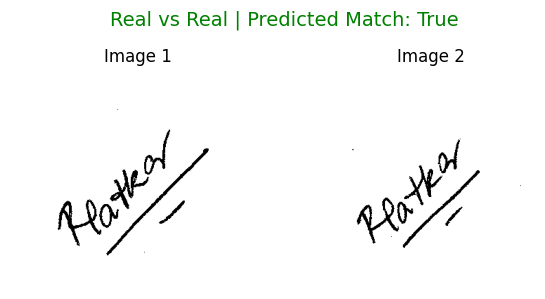

Distance: 0.2357 | Match: True


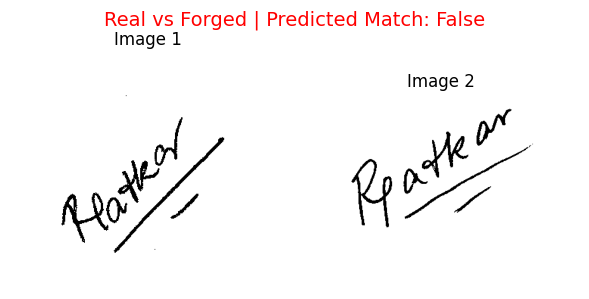

Distance: 0.8196 | Match: False


In [21]:
# Example real vs. real (should return True if genuine match)
img_path1 = 'iti/Computer_Vision/Day01/Siamese/personA/Test/personA_29.png'
img_path2 = 'iti/Computer_Vision/Day01/Siamese/personA/Test/personA_13.png'

# Example real vs. forged (should return False if forged)
img_path3 = 'iti/Computer_Vision/Day01/Siamese/personA/Test/personA_29.png'
img_path4 = 'iti/Computer_Vision/Day01/Siamese/personA/Test/personA_33.png'

# Real vs Real
match1, dist1 = test_signature_pair(img_path1, img_path2, model)
show_pair(img_path1, img_path2, "Real vs Real", match1)
print(f"Distance: {dist1:.4f} | Match: {match1}")

# Real vs Forged
match2, dist2 = test_signature_pair(img_path3, img_path4, model)
show_pair(img_path3, img_path4, "Real vs Forged", match2)
print(f"Distance: {dist2:.4f} | Match: {match2}")
